<a href="https://colab.research.google.com/github/robfonti/Deep-Learning/blob/Projects/Multiclass_Classification_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classifying reuters news articles into one of 46 classes. This is a widely used data set for text classification.  There are 46 different topics, some of which are more well represented than others, but all of which have at least 10 examples in the training set.  This data set comes pre-packaged in keras.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from tensorflow import keras

In [ ]:
from keras.datasets import reuters

(train_data,train_labels),(test_data,test_labels) = reuters.load_data(num_words = 10000)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [ ]:
print("Length of training data:",len(train_data))
print("Length of test data:",len(test_data))

Length of training data: 8982
Length of test data: 2246


Each example is a list of integers (word indices). Ex a 400 word article would be a list of length 400, with each integer corresponding to a unique word in the dictionary.

In [ ]:
# Heres how to decode the list of integers back to words
word_index = reuters.get_word_index() # Just tells you what word corresponds to what integer.

# We need to reverse this. We need what integer corresponds to what word
int_to_word_dict = dict([(value,key) for key,value in word_index.items()])
 
# the indices are off by 3, because 0,1,and 2 are reserved for "padding","start of sequence", and "unknown"
def decode_newswire(coded_newswire):  
  decoded_newswire = ' '.join(int_to_word_dict.get(i-3,'?') for i in coded_newswire) # I believe the '?' just defaults to a ? for numbers not seen. (0,1,2)
  return decoded_newswire

decode_newswire(train_data[0])            

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

Next we have to vectorize the data.  Remember, we can not feed lists into a neural network.  Data and labels need to be in the form of numpy tensors.

In [ ]:
def vectorize_sequences(sequences, dimension = 10000):  # This is a one-hot encoding
  # This is a matrix. a 2D tensor, with all possible words as columns, and length of training data (all reviews) set as rows. 
  vectorized_output = np.zeros((len(sequences),dimension)) 

  for i,sequence in enumerate(sequences):
    vectorized_output[i,sequence] = 1
  
  return vectorized_output


In [ ]:
# Now to vectorize the data

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

# Now to vectorize the labels. Same thing, one hot encoding to create an all zero vector except for where the category is. categories 0-46

# This function will take in a list of labels 0-46 (ex. [2,15,9,18,....]) and return a matrix of 0's with a 1 in the location of the label.
# Rows are size of training data
def onehot_labels(labels,dimension=46):
  one_hotted_labels = np.zeros((len(labels),dimension))
  for i,label in enumerate(labels):
    one_hotted_labels[i,label] = 1
  return one_hotted_labels

OH_train_labels = onehot_labels(train_labels)
OH_test_labels = onehot_labels(test_labels)

**NOTE: Now that you've done this twice, know that there is a built in way to one hot encode labels in keras.**

The method is called *to_categorical* 

In [ ]:
from keras.utils.np_utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


Now lets build our network.  There are now 46 outputs, we'll need 46 output nodes in the final layer.

Also, the number of units in the initial layers should be greater than 46. We used 16 for the binary classifcation problem, but 16 neurons will likely be too few to effectively distinguish between 46 different classes.  If we lose information in the first layer, that information can never be recovered.  We dont want any information bottlenecks, and therefore we should choose a higher number of neurons in these layers.

In [ ]:
# Layout the network
model = keras.Sequential()
model.add(keras.layers.Dense(units=64,input_shape=(10000,),activation='relu'))
model.add(keras.layers.Dense(units=64,activation='relu'))
model.add(keras.layers.Dense(units=46,activation='softmax')) # Last layer softmax to confer probability of entry falling into each of the 46 catgories

# Choose optimizer, loss, metrics
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
# Lets set aside some validation data.

x_val = x_train[0:1000]
val_labels = train_labels[0:1000]

partial_x_train = x_train[1000:]
partial_x_train_labels = train_labels[1000:]

In [ ]:
# Fitting the model, evaluating on the training data.

model.fit(partial_x_train,
          partial_x_train_labels,
          validation_data=(x_val,val_labels),
          batch_size=512,epochs=20)

Epoch 1/20
16/16 [==============================] - 2s 71ms/step - loss: 3.1046 - accuracy: 0.4228 - val_loss: 1.7214 - val_accuracy: 0.6410
Epoch 2/20
16/16 [==============================] - 1s 51ms/step - loss: 1.4780 - accuracy: 0.6895 - val_loss: 1.2999 - val_accuracy: 0.6990
Epoch 3/20
16/16 [==============================] - 1s 49ms/step - loss: 1.0636 - accuracy: 0.7655 - val_loss: 1.1201 - val_accuracy: 0.7690
Epoch 4/20
16/16 [==============================] - 1s 49ms/step - loss: 0.8410 - accuracy: 0.8276 - val_loss: 1.0267 - val_accuracy: 0.7730
Epoch 5/20
16/16 [==============================] - 1s 49ms/step - loss: 0.6739 - accuracy: 0.8629 - val_loss: 0.9587 - val_accuracy: 0.7920
Epoch 6/20
16/16 [==============================] - 1s 48ms/step - loss: 0.5047 - accuracy: 0.8973 - val_loss: 0.8978 - val_accuracy: 0.8050
Epoch 7/20
16/16 [==============================] - 1s 49ms/step - loss: 0.4102 - accuracy: 0.9154 - val_loss: 0.8886 - val_accuracy: 0.8110
Epoch 8/20
16

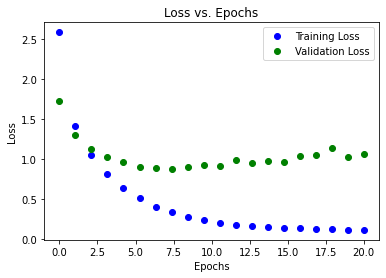

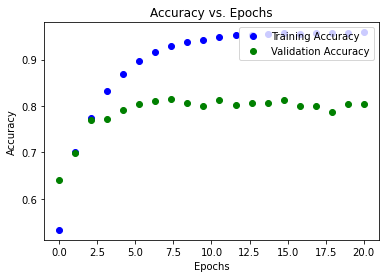

In [ ]:
# Lets plot the training/validation results

history_dict = model.history
loss = history_dict.history['loss']
val_loss = history_dict.history['val_loss']
training_acc = history_dict.history['accuracy']
val_acc = history_dict.history['val_accuracy']
epochs = tf.linspace(0,20,20)

plt.plot(epochs,loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'go',label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=1)
plt.title("Loss vs. Epochs")
plt.show()

plt.plot(epochs,training_acc,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc,'go',label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=1)
plt.title("Accuracy vs. Epochs")
plt.show()

In [ ]:
print(val_acc)

# Looks like the model starts to overfit after 8 epochs.  Lets train a new model and stop at 8 epochs

model2 = keras.Sequential()
model2.add(keras.layers.Dense(units=64,input_shape=(10000,),activation='relu'))
model2.add(keras.layers.Dense(units=64,activation='relu'))
model2.add(keras.layers.Dense(units=46,activation='softmax'))

model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

[0.640999972820282, 0.6990000009536743, 0.7689999938011169, 0.7730000019073486, 0.7919999957084656, 0.8050000071525574, 0.8109999895095825, 0.8159999847412109, 0.8069999814033508, 0.800000011920929, 0.8130000233650208, 0.8029999732971191, 0.8069999814033508, 0.8059999942779541, 0.8140000104904175, 0.8009999990463257, 0.8009999990463257, 0.7870000004768372, 0.8050000071525574, 0.8050000071525574]


In [ ]:
history2 = model2.fit(partial_x_train,
           partial_x_train_labels,
           validation_data=(x_val,val_labels),
           batch_size=512,
           epochs=8)

Epoch 1/8
16/16 [==============================] - 1s 63ms/step - loss: 3.2218 - accuracy: 0.3639 - val_loss: 1.8015 - val_accuracy: 0.6540
Epoch 2/8
16/16 [==============================] - 1s 50ms/step - loss: 1.5683 - accuracy: 0.6929 - val_loss: 1.3645 - val_accuracy: 0.7160
Epoch 3/8
16/16 [==============================] - 1s 49ms/step - loss: 1.1435 - accuracy: 0.7601 - val_loss: 1.1760 - val_accuracy: 0.7500
Epoch 4/8
16/16 [==============================] - 1s 48ms/step - loss: 0.8871 - accuracy: 0.8071 - val_loss: 1.0567 - val_accuracy: 0.7830
Epoch 5/8
16/16 [==============================] - 1s 50ms/step - loss: 0.6872 - accuracy: 0.8542 - val_loss: 0.9997 - val_accuracy: 0.7880
Epoch 6/8
16/16 [==============================] - 1s 49ms/step - loss: 0.5653 - accuracy: 0.8796 - val_loss: 0.9388 - val_accuracy: 0.8200
Epoch 7/8
16/16 [==============================] - 1s 48ms/step - loss: 0.4559 - accuracy: 0.9064 - val_loss: 0.9151 - val_accuracy: 0.8200
Epoch 8/8
16/16 [===

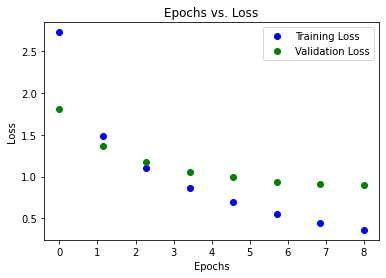

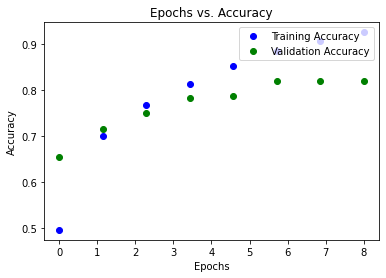

In [ ]:
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = tf.linspace(0,8,8)

plt.plot(epochs,train_loss,'bo',label='Training Loss')
plt.plot(epochs,val_loss,'go',label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs. Loss")
plt.legend(loc=1)
plt.show()

plt.plot(epochs,train_acc,'bo',label='Training Accuracy')
plt.plot(epochs,val_acc,'go',label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Epochs vs. Accuracy")
plt.legend(loc=1)
plt.show()

In [ ]:
# Now lets get some results!

results = model2.evaluate(x_test,test_labels)
results

71/71 [==============================] - 0s 3ms/step - loss: 0.9794 - accuracy: 0.7850


[0.9794387221336365, 0.7849510312080383]

In [ ]:
# We can examine the prections to get a feel for some things

predictions = model2.predict(x_test)

# Can inspect 1st prediction just to get a feel for the output.
print(predictions[0].shape)
print(predictions[0])
print(max(predictions[0]))
print(np.argmax(predictions[0])) # np.argmax is a super useful function

(46,)
[2.30626611e-05 9.94680304e-05 2.73294045e-05 7.82320321e-01
 2.08567217e-01 1.29967839e-05 7.92603314e-05 1.88695398e-04
 7.71638006e-04 6.95763592e-05 3.09880534e-06 8.42408452e-04
 6.17862534e-05 1.06866784e-04 2.01561008e-04 2.32153652e-05
 2.00302713e-03 2.31787199e-04 1.40359771e-04 6.22824591e-04
 5.93177159e-04 1.14088398e-04 2.17227152e-05 9.86266332e-06
 3.07521213e-06 3.85315827e-04 2.09547306e-06 2.48932738e-05
 1.42355188e-04 1.60040508e-04 7.75462286e-06 2.59247201e-04
 3.59243713e-05 1.03224074e-05 2.71069788e-04 4.14500500e-05
 1.56533817e-04 1.14530892e-04 6.87773763e-07 7.52878317e-04
 2.03574837e-05 3.14143283e-04 2.28988051e-06 2.13161347e-05
 1.29757856e-04 8.61166791e-06]
0.7823203
3


## Key Takeaways
- If you're trying to classify data points amond *N* classes, your network should end with a Dense layer with *N* units.
- In a single label, multiclass classification problem, your network should end with a *softmax* activation function to encode the probabilities of each observation falling into each of the *N* classes.
- Categorical crossentropy is almost always the loss function that you should choose when doing a multiclass classification problem.  It minimizes the distance between the probability distributions output by the network and the true distribution of the targets.
- There are 2 ways to handle labels in multiclass classification:
  - Encoding the labels via categorical encoding (aka one-hot encoding) and using a categorical cross-entropy loss function
  - Encoding the labels as integers and using a sparse_categorical_crossentropy loss function
- If you need to classify into a large number of subgroups (in this case 46), you should avoid including intermediate layers with less than *N* neurons.  This avoids information bottlenecks.  Very hard to encode information about 46 classes in a much lower dimensional space.